### Import Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [4]:
data=pd.read_csv('datasets/tweets.csv')

### Check for null values

In [5]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

In [6]:
#get stopword list
sw_list=stopwords.words('english')

### Since it might affect final outcome, a few words are removed from stopwords list

In [7]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->True
No------>True
Against->True


In [8]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [9]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->False
No------>False
Against->False


In [10]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Function to clean tweets

In [11]:
#Get nltk tag for lemmatizing a given token
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [12]:
# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)
    

In [13]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()


In [14]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs)

In [15]:
data[data['tweets']=='']

,tweets,labels
446,,0
905,,0
1067,,0
1082,,0
1093,,0
1101,,0
1290,,0


In [16]:
len(data)

1364

In [17]:
data.eq('').sum()

tweets    7
labels    0
dtype: int64

In [18]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [19]:
len(data)

1357

### Train-Test split

In [20]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [21]:
lengths=pd.DataFrame(len(tweet.split(' ')) for tweet in X_train)

In [22]:
test_length=pd.DataFrame(len(tweet.split(' ')) for tweet in X_test)

In [23]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

### Get word count of tweet with most words

In [24]:
max_len

24

## Modeled using : max_features=max_len

### TF-IDF Vectorization

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tfidf_vect=TfidfVectorizer(max_features=max_len)
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### Combined dataframe of training data

In [27]:
train_data=pd.concat((X_train,y_train),axis=1,ignore_index=True)
train_data.columns=['tweets','labels']
train_data.reset_index(inplace=True,drop=True)
train_data=pd.concat((train_data,X_train_tfidf),axis=1)
train_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,obama admin cry tax increase applaud china low...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.0,0.000000
1,barack obama longboard package core truck mm b...,0,0.0,0.966024,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,edshow whenever obama tell truth gop boo hoo h...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.96201,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,many foreign leader obama promise post electio...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.0,0.000000
4,obama signal us would accept iranian civilian ...,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,mean saving scotus tell world obama wrong aca ...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1081,obama sharpen kansas vision,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1082,genius man sing else really obama,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1083,mitt romney obama spend much time harvard also...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.63229,0.0,0.000000,0.0,0.0,0.0,0.749274


### Combined dataframe of test data

In [28]:
test_data=pd.concat((X_test,y_test),axis=1,ignore_index=True)
test_data.columns=['tweets','labels']
test_data.reset_index(inplace=True,drop=True)
test_data=pd.concat((test_data,X_test_tfidf),axis=1)
test_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,harry style describe michelle obama como una m...,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,amp si khady president obama get elect nyrell ...,0,0.000000,0.000000,0.0,0.000000,0.0,0.649992,0.0,0.0,...,0.0,0.536398,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,obama black american really need time whitey f...,0,0.954988,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,whatsromneyhiding throw baseball like man not ...,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.290948,0.0
4,realclearpolitics obama organizational advanta...,2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,romney attack obama barnstorm pennsylvania,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.954745,0.0,0.0,0.0,0.0,0.000000,0.0
268,obama thug bully not sure call rush limbaugh bill,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
269,michelle barack obama become like celebrity ta...,0,0.000000,0.760224,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
270,whatsromneyhiding nothing compare mt proof oba...,1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.947853,0.0


In [29]:
y_train.unique()

array([0, 1, 2], dtype=int64)

### Convert y_train and y_test to multi-class categorical format

In [30]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

### Create Tensorboard Callback

In [31]:
from tensorflow.keras.callbacks import TensorBoard

In [32]:
log_directory = 'logs-tfidf-1\\fit'

board_1 = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True)

### Create and train model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [34]:
tf.keras.backend.set_floatx('float64')

In [35]:
model=Sequential()
model.add(Dense(activation='relu',units=64))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
#Setting test data as validation data to see how the model performs on the test data over training period
history=model.fit(x=X_train_tfidf,y=y_train,epochs=20,callbacks=[board_1], validation_data=(X_test_tfidf,y_test))

Epoch 1/20
 1/34 [..............................] - ETA: 0s - loss: 1.0773 - accuracy: 0.4375WARNING:tensorflow:From C:\Users\varun\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 1s 22ms/step - loss: 0.8806 - accuracy: 0.6820 - val_loss: 0.7813 - val_accuracy: 0.6691
Epoch 2/20
34/34 [==============================] - 0s 6ms/step - loss: 0.7641 - accuracy: 0.6839 - val_loss: 0.7513 - val_accuracy: 0.6691
Epoch 3/20
34/34 [==============================] - 0s 6ms/step - loss: 0.7391 - accuracy: 0.6839 - val_loss: 0.7341 - val_accuracy: 0.6691
Epoch 4/20
34/34 [==============================] - 0s 7ms/step - loss: 0.7222 - accuracy: 0.6839 - val_loss: 0.7263 - val_accuracy: 0.6691
Epoch 5/20
34/34 [==============================] - 0s 6ms/step

### Get predictions from test data

In [37]:
y_predictions=(model.predict(X_test_tfidf) > 0.5).astype("int32")

In [38]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [39]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       182
           1       0.78      0.27      0.40        78
           2       0.00      0.00      0.00        12

   micro avg       0.74      0.68      0.71       272
   macro avg       0.51      0.39      0.40       272
weighted avg       0.72      0.68      0.66       272
 samples avg       0.68      0.68      0.68       272



### Accuracy

In [40]:
print(accuracy_score(y_test,y_predictions))

0.6801470588235294


In [41]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[176,   6,   0],
       [ 57,  21,   0],
       [ 12,   0,   0]], dtype=int64)

In [42]:
losses=pd.DataFrame(history.history)

<AxesSubplot:>

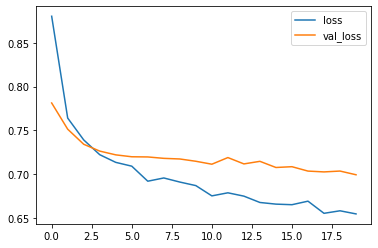

In [43]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

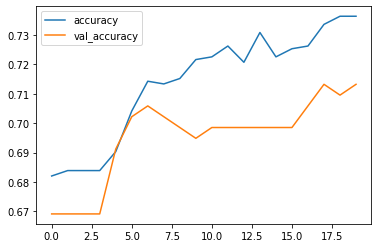

In [44]:
losses[['accuracy','val_accuracy']].plot()

In [45]:
print(log_directory)

logs-tfidf-1\fit


## Modeled without: max_features=max_len

### Reinitialize TF-IDF vectorizer and transform train and test data

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### New tensorboard callback

In [47]:
log_directory = 'logs-tfidf-2\\fit'

board_2 = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True)

### Create and train model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [49]:
model_2=Sequential()
model_2.add(Dense(activation='relu',units=64))
model_2.add(Dropout(0.2))
model_2.add(Dense(activation='relu',units=32))
model_2.add(Dense(activation='softmax',units=3))
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:
#Setting test data as validation data to see how the model performs on the test data over training period
history_2=model_2.fit(x=X_train_tfidf,y=y_train,epochs=20,callbacks=[board_2], validation_data=(X_test_tfidf,y_test))

Epoch 1/20
34/34 [==============================] - 2s 54ms/step - loss: 0.9774 - accuracy: 0.6452 - val_loss: 0.8361 - val_accuracy: 0.6691
Epoch 2/20
34/34 [==============================] - 0s 10ms/step - loss: 0.7399 - accuracy: 0.6885 - val_loss: 0.6748 - val_accuracy: 0.6985
Epoch 3/20
34/34 [==============================] - 0s 10ms/step - loss: 0.5906 - accuracy: 0.7548 - val_loss: 0.5677 - val_accuracy: 0.7721
Epoch 4/20
34/34 [==============================] - 0s 11ms/step - loss: 0.4683 - accuracy: 0.8101 - val_loss: 0.5004 - val_accuracy: 0.8125
Epoch 5/20
34/34 [==============================] - 0s 11ms/step - loss: 0.3605 - accuracy: 0.8682 - val_loss: 0.4579 - val_accuracy: 0.8235
Epoch 6/20
34/34 [==============================] - 0s 9ms/step - loss: 0.2757 - accuracy: 0.9014 - val_loss: 0.4466 - val_accuracy: 0.8346
Epoch 7/20
34/34 [==============================] - 0s 9ms/step - loss: 0.2135 - accuracy: 0.9235 - val_loss: 0.4356 - val_accuracy: 0.8493
Epoch 8/20
34/3

### Get new predictions

In [51]:
y_predictions=(model_2.predict(X_test_tfidf) > 0.5).astype("int32")

### Check accuracy and other metrics

In [52]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       182
           1       0.78      0.68      0.73        78
           2       0.83      0.42      0.56        12

   micro avg       0.84      0.84      0.84       272
   macro avg       0.82      0.68      0.73       272
weighted avg       0.83      0.84      0.83       272
 samples avg       0.84      0.84      0.84       272



In [53]:
print(accuracy_score(y_test,y_predictions))

0.8382352941176471


### As we can see, not setting a limit on max_len results in higher accuracy

In [54]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[170,  12,   0],
       [ 24,  53,   1],
       [  4,   3,   5]], dtype=int64)

<AxesSubplot:>

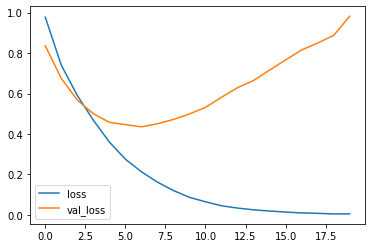

In [55]:
losses=pd.DataFrame(history_2.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

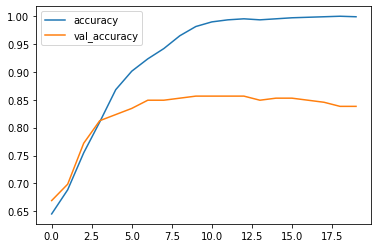

In [56]:
losses[['accuracy','val_accuracy']].plot()